In [4]:
# Import libraries
import shap
import joblib
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier


# Configure SHAP
shap.initjs()
%matplotlib inline

# Define paths
data_dir = r"C:\Users\yusuf\Desktop\10Academy\week8\Data"
assets_dir = os.path.join(data_dir, "assets")

# Load best models
best_ecom_model = joblib.load(os.path.join(data_dir, 'best_ecom_model.pkl'))
best_cc_model = joblib.load(os.path.join(data_dir, 'best_cc_model.pkl'))

# Load test sets
test_ecom = pd.read_csv(os.path.join(data_dir, 'test_ecom.csv'))
test_cc = pd.read_csv(os.path.join(data_dir, 'test_cc.csv'))

print("✅ Models and test sets loaded successfully")
print(f"E-commerce test shape: {test_ecom.shape}")
print(f"Credit Card test shape: {test_cc.shape}")

✅ Models and test sets loaded successfully
E-commerce test shape: (30223, 198)
Credit Card test shape: (56746, 33)


In [5]:
# Create SHAP explainers
def create_explainer(model, test_data):
    """Create appropriate SHAP explainer based on model type"""
    # Extract model from pipeline if needed
    if isinstance(model, Pipeline):
        model = model.named_steps['classifier']
    
    # Create explainer based on model type
    if isinstance(model, XGBClassifier):
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(test_data)
    else:  # For linear models like Logistic Regression
        explainer = shap.LinearExplainer(model, test_data)
        shap_values = explainer.shap_values(test_data)
    
    return explainer, shap_values

# Prepare data for SHAP (remove target columns)
X_test_ecom = test_ecom.drop(['actual', 'predicted', 'probability'], axis=1)
X_test_cc = test_cc.drop(['actual', 'predicted', 'probability'], axis=1)

# Create explainers
ecom_explainer, ecom_shap_values = create_explainer(best_ecom_model, X_test_ecom)
cc_explainer, cc_shap_values = create_explainer(best_cc_model, X_test_cc)

print("✅ SHAP explainers created")

✅ SHAP explainers created


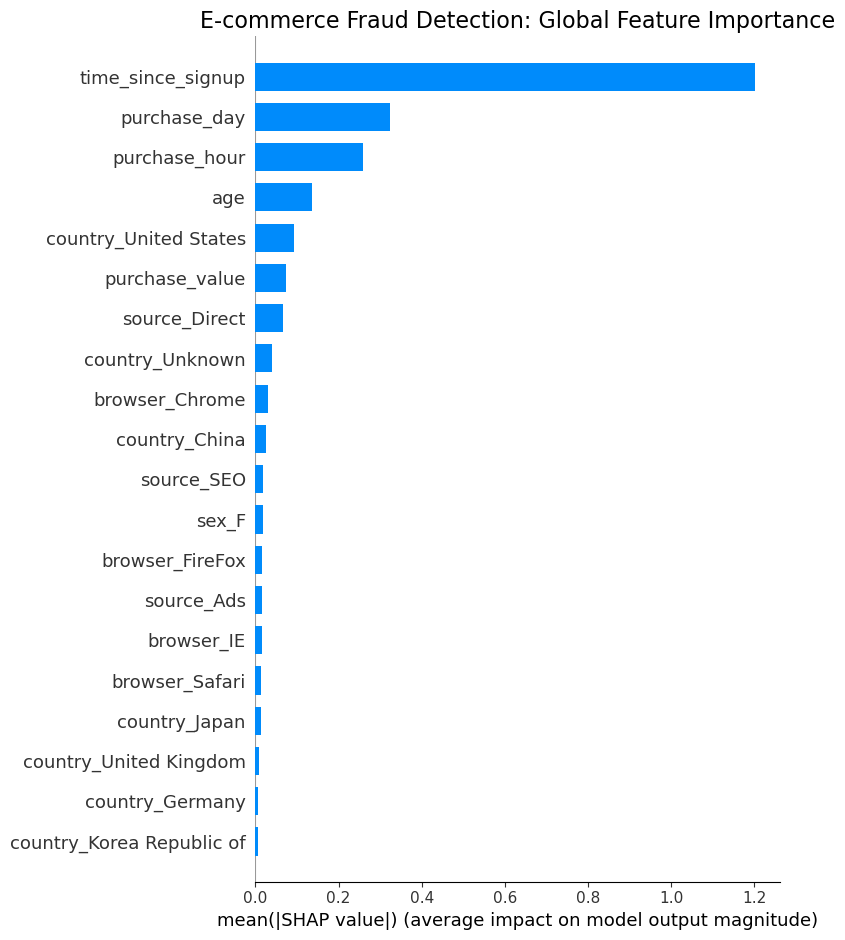

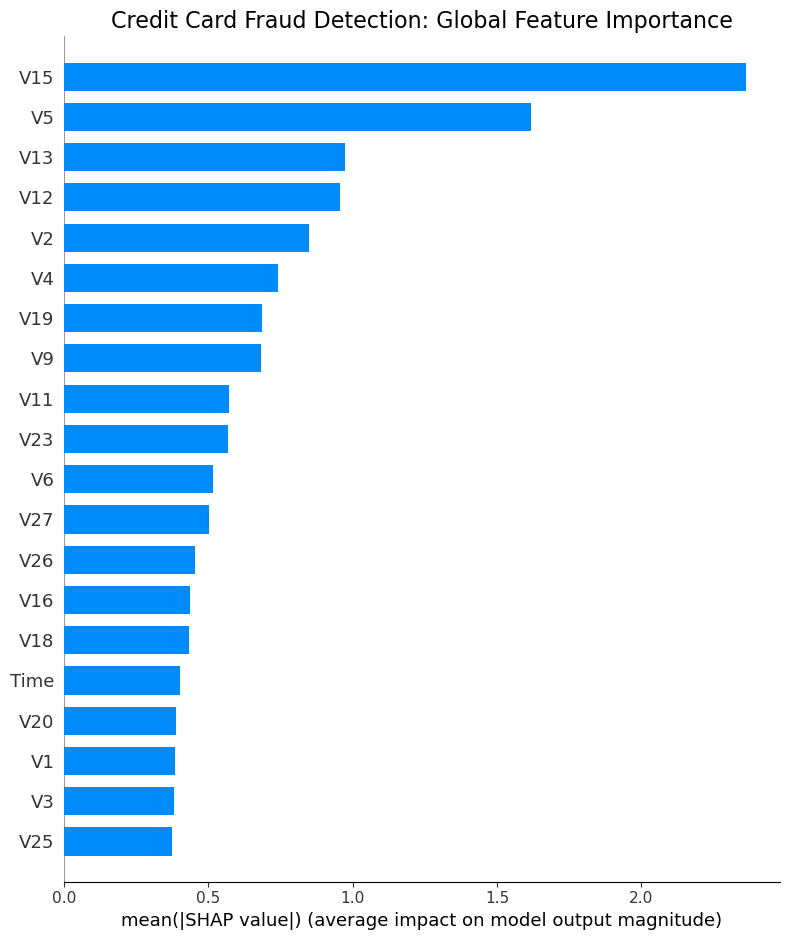

✅ Global feature importance plots saved


In [6]:
# Global feature importance for e-commerce
plt.figure(figsize=(12, 8))
shap.summary_plot(ecom_shap_values, X_test_ecom, plot_type="bar", show=False)
plt.title("E-commerce Fraud Detection: Global Feature Importance", fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(assets_dir, 'shap_global_ecom.png'), bbox_inches='tight')
plt.show()

# Global feature importance for credit card
plt.figure(figsize=(12, 8))
shap.summary_plot(cc_shap_values, X_test_cc, plot_type="bar", show=False)
plt.title("Credit Card Fraud Detection: Global Feature Importance", fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(assets_dir, 'shap_global_cc.png'), bbox_inches='tight')
plt.show()

print("✅ Global feature importance plots saved")

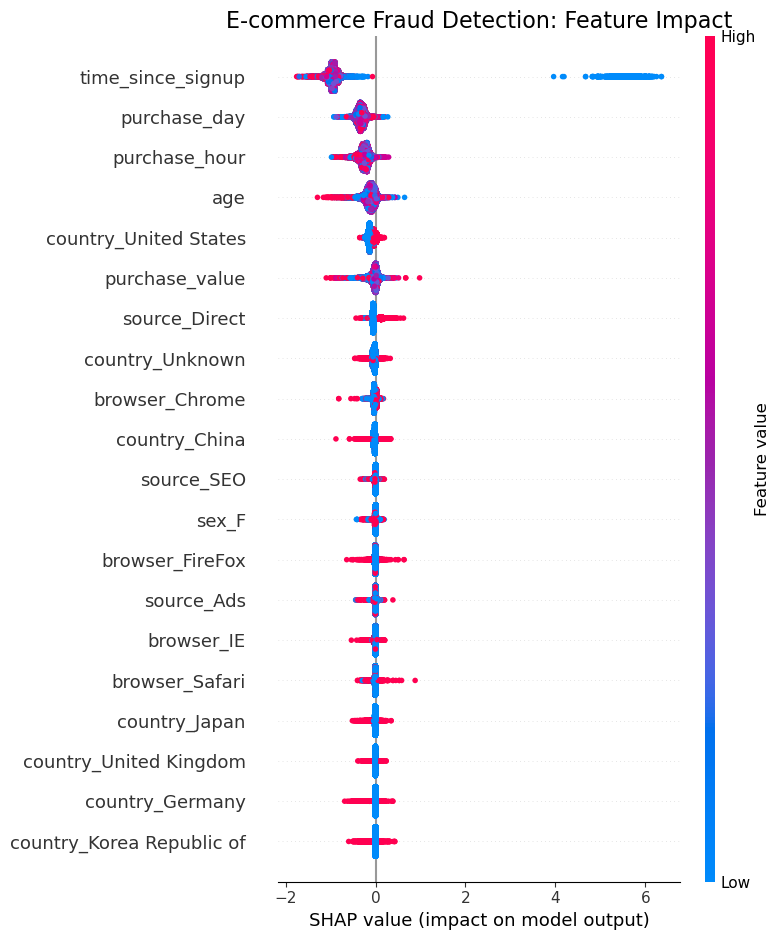

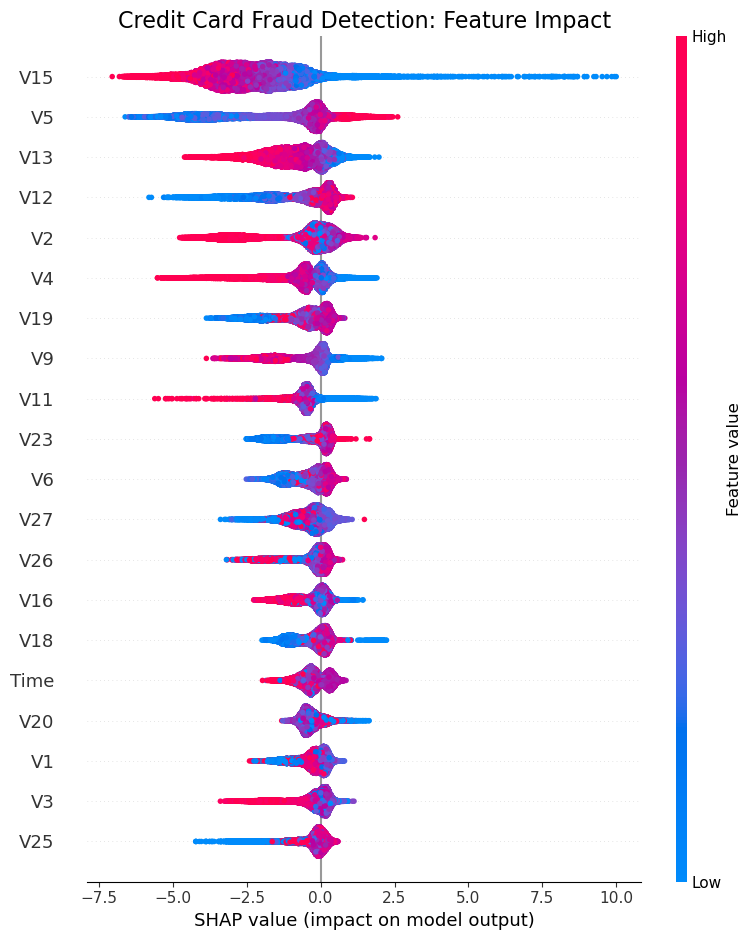

✅ Detailed summary plots saved


In [7]:
# Detailed summary plot for e-commerce
plt.figure(figsize=(12, 10))
shap.summary_plot(ecom_shap_values, X_test_ecom, show=False)
plt.title("E-commerce Fraud Detection: Feature Impact", fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(assets_dir, 'shap_summary_ecom.png'), bbox_inches='tight')
plt.show()

# Detailed summary plot for credit card
plt.figure(figsize=(12, 10))
shap.summary_plot(cc_shap_values, X_test_cc, show=False)
plt.title("Credit Card Fraud Detection: Feature Impact", fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(assets_dir, 'shap_summary_cc.png'), bbox_inches='tight')
plt.show()

print("✅ Detailed summary plots saved")


Analyzing E-commerce cases...


<Figure size 1000x400 with 0 Axes>

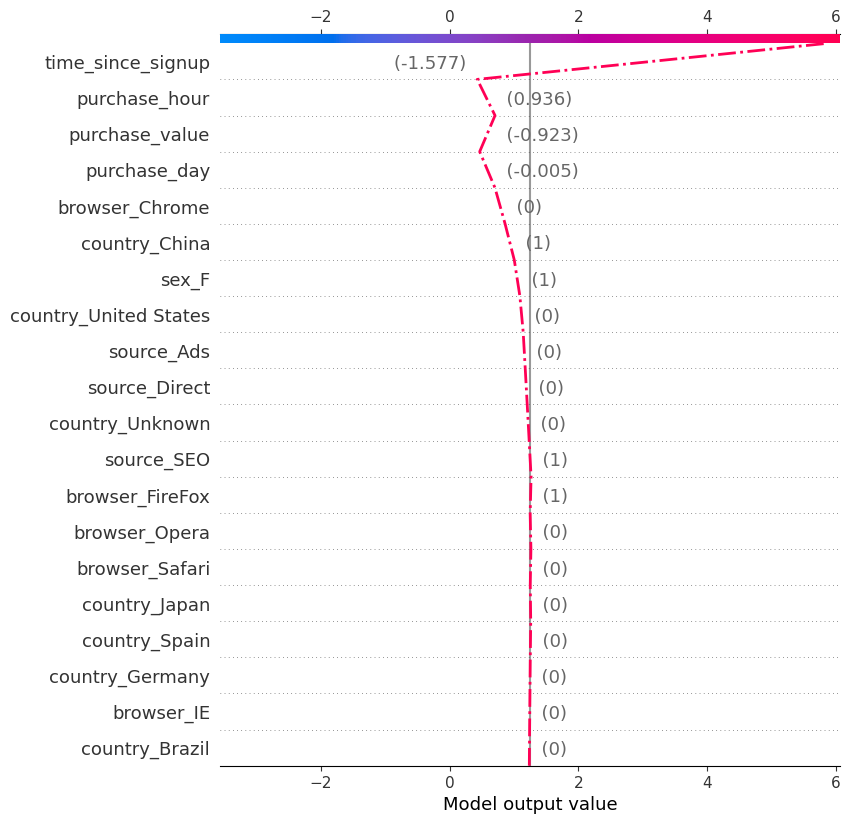

✅ Created visualizations for case 1


<Figure size 1000x400 with 0 Axes>

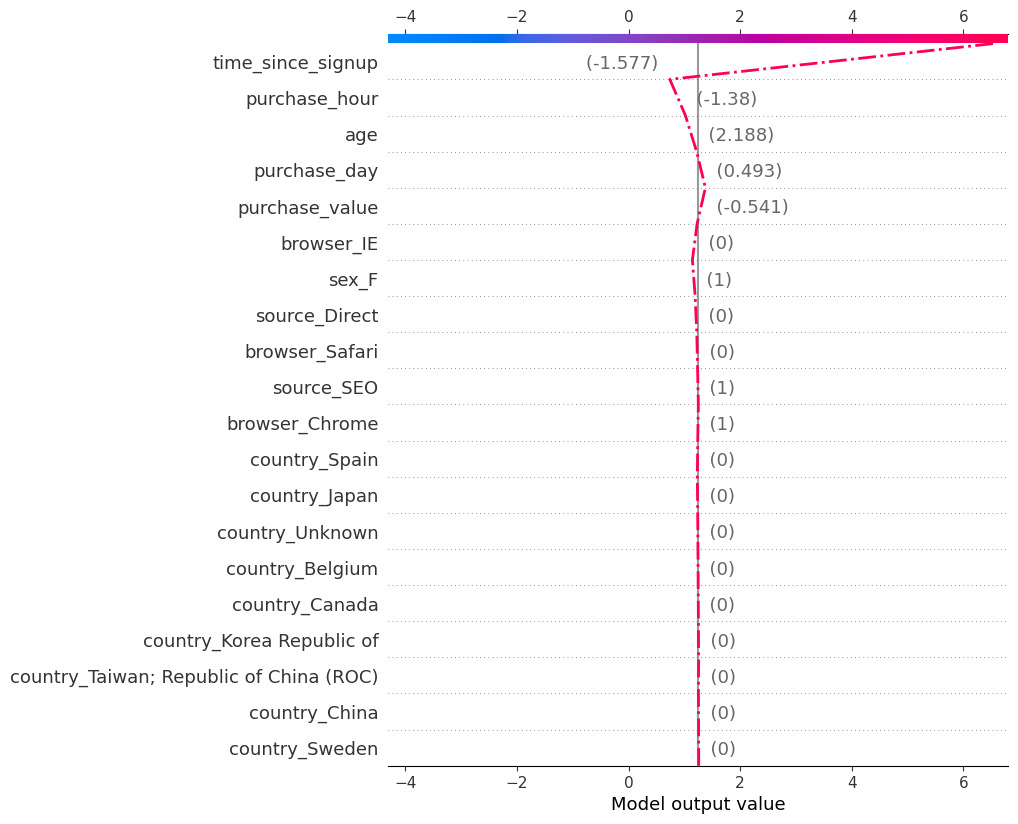

✅ Created visualizations for case 2


<Figure size 1000x400 with 0 Axes>

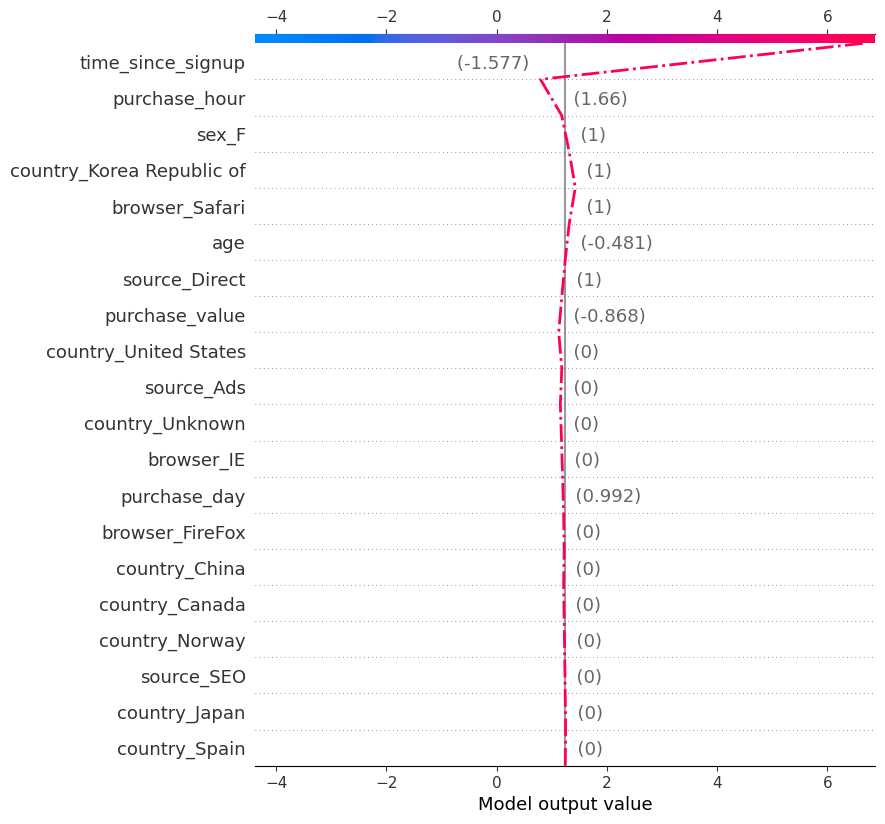

✅ Created visualizations for case 3

Analyzing Credit Card cases...
⚠️ Only 0 high-confidence fraud cases found for Credit_Card
⚠️ No high-confidence fraud cases available for Credit_Card

✅ Sample case visualizations saved


In [14]:
# Cell 5: Local Explainability - Sample Cases (Fixed)
def analyze_sample_cases(explainer, X_test, y_test, probabilities, dataset_name, n_cases=3):
    """Analyze and visualize sample fraud cases with robust error handling"""
    # Find high-confidence fraud cases
    fraud_mask = (y_test == 1) & (probabilities > 0.9)
    fraud_cases = X_test[fraud_mask]
    
    # Check if enough cases exist
    if len(fraud_cases) < n_cases:
        print(f"⚠️ Only {len(fraud_cases)} high-confidence fraud cases found for {dataset_name}")
        n_cases = min(len(fraud_cases), n_cases)
        if n_cases == 0:
            print(f"⚠️ No high-confidence fraud cases available for {dataset_name}")
            return
    
    # Sample cases (with replacement if needed)
    replace = len(fraud_cases) < n_cases
    fraud_cases = fraud_cases.sample(n_cases, replace=replace)
    
    for i, (idx, row) in enumerate(fraud_cases.iterrows()):
        try:
            # Convert to DataFrame for SHAP
            row_df = pd.DataFrame([row], columns=X_test.columns)
            
            # Get SHAP values
            shap_values = explainer.shap_values(row_df)
            
            # Force plot
            plt.figure(figsize=(10, 4))
            shap.force_plot(
                explainer.expected_value,
                shap_values[0],  # Get values for first (only) row
                row_df.iloc[0],
                matplotlib=True,
                show=False,
                text_rotation=15
            )
            plt.title(f"{dataset_name} Fraud Case {i+1}: Force Plot", fontsize=14)
            plt.tight_layout()
            plt.savefig(os.path.join(assets_dir, f'shap_force_{dataset_name}_case{i+1}.png'), bbox_inches='tight')
            plt.close()
            
            # Decision plot
            plt.figure(figsize=(12, 8))
            shap.decision_plot(
                explainer.expected_value,
                shap_values[0],
                row_df.iloc[0],
                feature_order='importance',
                highlight=0  # Highlight most important feature
            )
            plt.title(f"{dataset_name} Fraud Case {i+1}: Decision Plot", fontsize=14)
            plt.tight_layout()
            plt.savefig(os.path.join(assets_dir, f'shap_decision_{dataset_name}_case{i+1}.png'))
            plt.close()
            
            print(f"✅ Created visualizations for case {i+1}")
            
        except Exception as e:
            print(f"❌ Error processing case {i+1}: {str(e)}")
            import traceback
            traceback.print_exc()

# Analyze e-commerce cases
print("\nAnalyzing E-commerce cases...")
analyze_sample_cases(
    ecom_explainer, 
    X_test_ecom, 
    test_ecom['actual'],
    test_ecom['probability'],
    "E-commerce"
)

# Analyze credit card cases
print("\nAnalyzing Credit Card cases...")
analyze_sample_cases(
    cc_explainer, 
    X_test_cc, 
    test_cc['actual'],
    test_cc['probability'],
    "Credit_Card"  # Use underscore for filename safety
)

print("\n✅ Sample case visualizations saved")

⚠️ No matching high-confidence fraud case found.


<Figure size 1000x400 with 0 Axes>

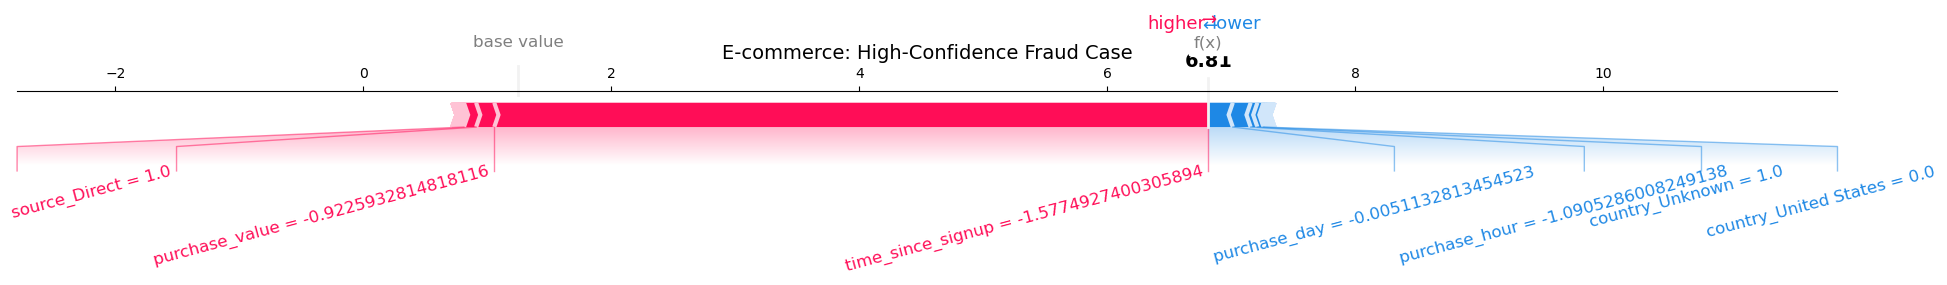

<Figure size 1000x400 with 0 Axes>

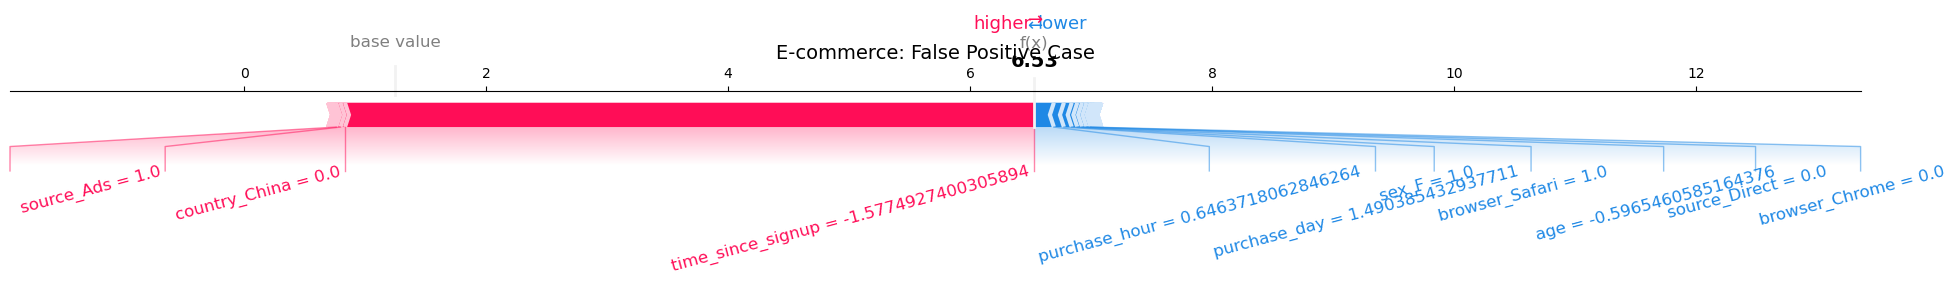

<Figure size 1000x400 with 0 Axes>

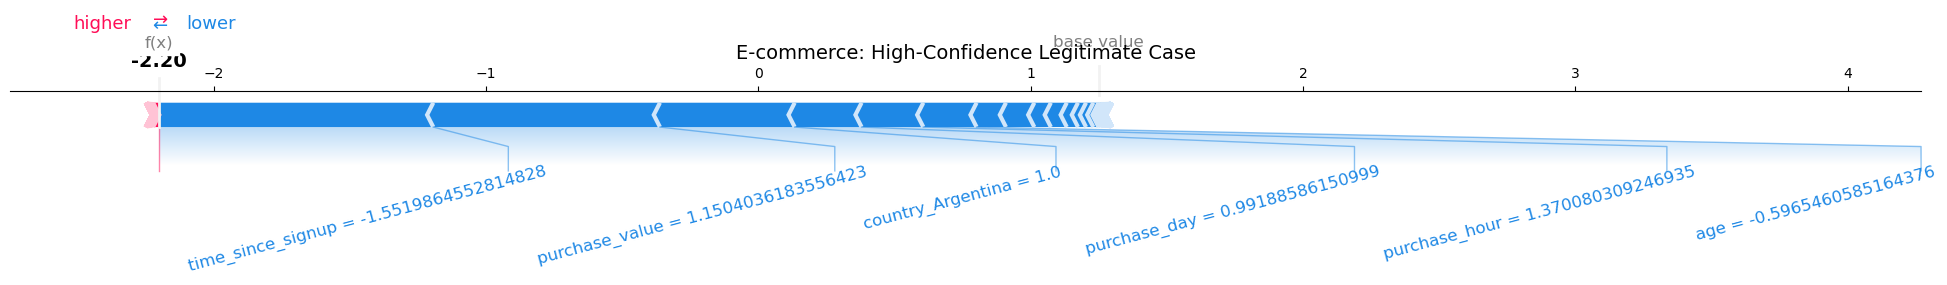

⚠️ Skipping plot for 'Credit Card: High-Confidence Fraud Case' - empty case.


<Figure size 1000x400 with 0 Axes>

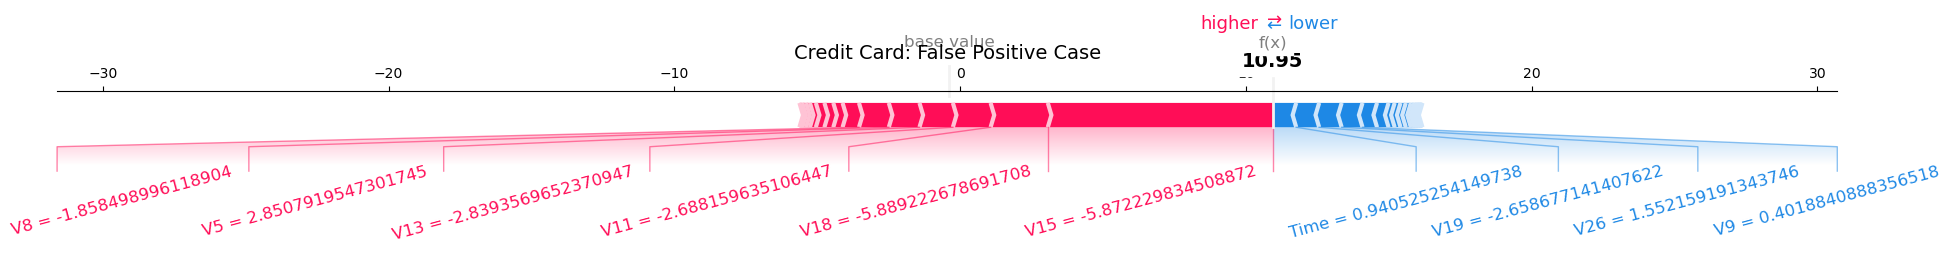

<Figure size 1000x400 with 0 Axes>

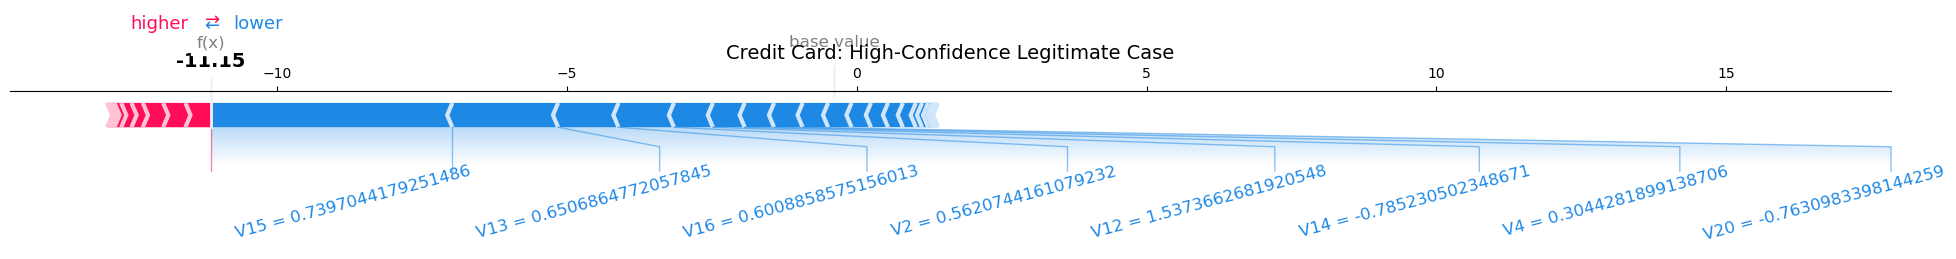

In [18]:
# Find representative cases
def find_representative_cases(X_test, y_test, probabilities):
    """Find representative fraud and legitimate cases with fallback handling"""
    
    def safe_get_case(condition, case_name):
        filtered = X_test[condition]
        if not filtered.empty:
            return filtered.iloc[0]
        else:
            print(f"⚠️ No matching {case_name} found.")
            return pd.Series(index=X_test.columns, dtype='float64')  # return empty row with correct shape

    # High-confidence fraud
    fraud_case = safe_get_case((y_test == 1) & (probabilities > 0.9), "high-confidence fraud case")
    
    # False positive
    false_positive = safe_get_case((y_test == 0) & (probabilities > 0.7), "false positive case")
    
    # High-confidence legitimate
    legitimate_case = safe_get_case((y_test == 0) & (probabilities < 0.1), "high-confidence legitimate case")
    
    return fraud_case, false_positive, legitimate_case

# E-commerce cases
ecom_cases = find_representative_cases(X_test_ecom, test_ecom['actual'], test_ecom['probability'])
cc_cases = find_representative_cases(X_test_cc, test_cc['actual'], test_cc['probability'])

# Plot force plots
def plot_force(explainer, case, title, file_name):
    """Enhanced force plot visualization"""
    if case.isnull().all():
        print(f"⚠️ Skipping plot for '{title}' - empty case.")
        return

    case_df = case.to_frame().T  # Convert to 2D DataFrame
    shap_values = explainer.shap_values(case_df)

    plt.figure(figsize=(10, 4))
    shap.force_plot(
        explainer.expected_value,
        shap_values[0],
        case_df.iloc[0],
        matplotlib=True,
        text_rotation=15,
        contribution_threshold=0.05,
        show=False
    )
    plt.title(title, fontsize=14)
    plt.tight_layout()
    plt.savefig(os.path.join(assets_dir, file_name), dpi=300, bbox_inches='tight')
    plt.show()

# E-commerce force plots
plot_force(ecom_explainer, ecom_cases[0], 
           "E-commerce: High-Confidence Fraud Case", "shap_force_ecom_fraud.png")
plot_force(ecom_explainer, ecom_cases[1], 
           "E-commerce: False Positive Case", "shap_force_ecom_fp.png")
plot_force(ecom_explainer, ecom_cases[2], 
           "E-commerce: High-Confidence Legitimate Case", "shap_force_ecom_legit.png")

# Credit card force plots
plot_force(cc_explainer, cc_cases[0], 
           "Credit Card: High-Confidence Fraud Case", "shap_force_cc_fraud.png")
plot_force(cc_explainer, cc_cases[1], 
           "Credit Card: False Positive Case", "shap_force_cc_fp.png")
plot_force(cc_explainer, cc_cases[2], 
           "Credit Card: High-Confidence Legitimate Case", "shap_force_cc_legit.png")


In [21]:
# Enhanced decision plots (corrected version)
def plot_decision(explainer, case, title, file_name):
    """Custom decision plot with highlighting, fixed for single-row input"""
    # Convert Series to DataFrame for SHAP compatibility
    case_df = case.to_frame().T
    shap_values = explainer.shap_values(case_df)

    plt.figure(figsize=(12, 8))
    shap.decision_plot(
        explainer.expected_value,
        shap_values[0],             # SHAP values for first (only) row
        features=case_df.iloc[0],   # Corresponding feature values
        feature_order='importance',
        highlight=0,
        show=False
    )
    plt.title(title, fontsize=16)
    plt.xlabel("Model Output Value", fontsize=12)
    plt.ylabel("Features", fontsize=12)
    plt.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.savefig(os.path.join(assets_dir, file_name), dpi=300)
    plt.show()


In [22]:
# Enhanced decision plots
def plot_decision(explainer, case, title, file_name):
    """Custom decision plot with highlighting"""
    plt.figure(figsize=(12, 8))
    shap.decision_plot(
        explainer.expected_value,
        explainer.shap_values(case),
        features=case,
        feature_order='importance',
        highlight=0,
        show=False
    )
    plt.title(title, fontsize=16)
    plt.xlabel("Model Output Value", fontsize=12)
    plt.ylabel("Features", fontsize=12)
    plt.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.savefig(os.path.join(assets_dir, file_name), dpi=300)
    plt.show()

# E-commerce decision plots
plot_decision(ecom_explainer, ecom_cases[0], 
              "E-commerce: Fraud Case Prediction Pathway", "shap_decision_ecom_fraud.png")
plot_decision(ecom_explainer, ecom_cases[1], 
              "E-commerce: False Positive Analysis", "shap_decision_ecom_fp.png")

# Credit card decision plots
plot_decision(cc_explainer, cc_cases[0], 
              "Credit Card: Fraud Case Prediction Pathway", "shap_decision_cc_fraud.png")
plot_decision(cc_explainer, cc_cases[1], 
              "Credit Card: False Positive Analysis", "shap_decision_cc_fp.png")

XGBoostError: [20:48:11] D:\bld\xgboost-split_1744329010901\work\src\c_api\c_api_utils.h:129: Check failed: std::accumulate(shape.cbegin(), shape.cend(), static_cast<bst_ulong>(1), std::multiplies<>{}) == chunksize * rows (390 vs. 38220) : 

In [23]:
# Create comprehensive explanation report
def generate_shap_report(shap_values, X_test, model_name):
    """Generate detailed SHAP report with key insights"""
    # Calculate mean absolute SHAP values
    importance = pd.DataFrame({
        'feature': X_test.columns,
        'importance': np.abs(shap_values).mean(axis=0)
    }).sort_values('importance', ascending=False)
    
    # Top 3 drivers of fraud
    top_drivers = importance.head(3)['feature'].tolist()
    
    # Top 3 protectors against fraud
    bottom_drivers = importance.tail(3)['feature'].tolist()
    
    # Generate report
    report = f"""
    {model_name} Fraud Detection Model Explainability Report
    ======================================================
    
    Key Findings:
    -------------
    1. Top Fraud Indicators:
       - {top_drivers[0]} (Impact: {importance.iloc[0]['importance']:.4f})
       - {top_drivers[1]} (Impact: {importance.iloc[1]['importance']:.4f})
       - {top_drivers[2]} (Impact: {importance.iloc[2]['importance']:.4f})
    
    2. Top Fraud Preventers:
       - {bottom_drivers[0]} (Impact: {importance.iloc[-1]['importance']:.4f})
       - {bottom_drivers[1]} (Impact: {importance.iloc[-2]['importance']:.4f})
       - {bottom_drivers[2]} (Impact: {importance.iloc[-3]['importance']:.4f})
    
    3. Model Behavior Insights:
       - Features with positive SHAP values increase fraud probability
       - Features with negative SHAP values decrease fraud probability
       - The base value (average prediction) is {explainer.expected_value:.4f}
    
    Business Recommendations:
    ------------------------
    1. Fraud Detection Strategy:
       - Prioritize monitoring of transactions with high values in: {top_drivers[0]} and {top_drivers[1]}
       - Consider whitelisting patterns with high values in: {bottom_drivers[0]}
    
    2. System Improvements:
       - Create alert thresholds based on {top_drivers[0]} values
       - Implement real-time SHAP scoring for transaction risk assessment
    """
    return report, importance

# Generate reports
ecom_report, ecom_importance = generate_shap_report(ecom_shap_values, X_test_ecom, "E-commerce")
cc_report, cc_importance = generate_shap_report(cc_shap_values, X_test_cc, "Credit Card")

# Save reports
with open(os.path.join(assets_dir, 'shap_report_ecom.txt'), 'w') as f:
    f.write(ecom_report)
    
with open(os.path.join(assets_dir, 'shap_report_cc.txt'), 'w') as f:
    f.write(cc_report)

print("📝 Explanation Reports Generated:")
print(ecom_report)
print(cc_report)

NameError: name 'explainer' is not defined